# Death to Cluster Models; Long Live Context Encoders

Regression and modeling are the backbone of data science. 
Regression distills complex and noisy observations from the real world into interpretable and mechanistic models, discovering meaningful behavior in the midst of randomness.
However, choosing a model makes implicit assumptions about what is meaningful and what is noise in the data, and how we can interpret the data.


For instance, personalized medicine is based on the idea that diseases can have different behaviors in different patients.
If we want to do personalized medicine, we ought to base our studies on personalized models.
Traditional regression methods will produce a single model that represents our whole patient population, implying that our disease behaves the same in all patients.
For highly heterogeneous diseases and disorders like cancer, Alzheimer's, diabetes, COVID-19, and sepsis, this won't help us understand how the disease varies among patients.
Traditional modeling methods only provide a general understanding of the disease for the majority of patients, marginalizing underrepresented or minority subpopulations.
In data with complex or heterogeneous behavior, we need models that can represent meaningful variation between patients while still separating true mechanisms from random noise. 


In this demo, we simulate how a patient's unique risk factors can create highly individualized disease behaviors that require personalized treatment, and compare how well we can model this behavior with traditional methods, including population modeling and cluster analysis, and contextualized modeling

## Section 1: Problem Setup and Data Exploration

### 1.1: Problem Overview
We have a dataset of patients where we've measured each patient's response $Y$ to a randomized dose of treatments $A$ and $B$, and we also know each patient's risk factors: diet $C_1$ and exercise $C_2$.
We know that diet and exercise have some effect on response to treatment (treatment dose effects $\beta_A$, $\beta_B$), but it isn't a simple or obvious relationship. 
Let's also use relative values for $C_1, C_2, A, B$, so they center around zero and negative values will tell us how much lower than average a patient is, and positive values tell us how much higher than average a patient is.
Here's how we simulate this:

$$C_1, C_2 \sim \text{Uniform}[-1, 1]$$

$$A, B \sim \text{Uniform}[-1, 1]$$

$$\beta_A = C_1 + C_2^2 \hspace{10pt} \beta_B = C_1^2 + C_2$$

$$Y = \beta_A * A + \beta_B * B$$

We draw random values $C_1, C_2, A, B$ for each patient (their risk factors and randomized dose) and determine $Y$ based on the functions above.
However, we don't know these functions in reality.
Our goal is to recover the treatment effect values $\beta_A, \beta_B$ for each patient as closely as possible so that we know how these patients will respond to treatment and tailor their treatment process, and simultaneously predict their outcome from treatment.

In [1]:
%%capture
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
# Generate our data and do some plotting
n_z = 75  # total number of patients in our study
Z_space = np.linspace(-1, 1, n_z)
Z = np.zeros((n_z**2, 2))
for i, z_i in enumerate(Z_space):
    for j, z_j in enumerate(Z_space):
        Z[i * n_z + j] = [z_i, z_j]
z_samples = 1  # total number of randomized treatments each patient receives
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()
C = C[::-1]

betas = np.zeros_like(Z_labels)
betas[:,0] = C[:,0] + C[:,1]**2 
betas[:,1] = C[:,0]**2 + C[:,1] 
betas = np.repeat(betas, z_samples, axis=0)
# betas += np.random.normal(0, .1, betas.shape)  # add noise to the true parameters if you'd like
X = np.random.uniform(-1, 1, betas.shape)
Y = (X * betas).sum(axis=1)[:, np.newaxis]
# Y += np.random.normal(0, .1, Y.shape)  # add noise to the outcomes if you'd like

def get_gaps(Z):
    dist = lambda a, b: np.sqrt(np.sum((a - b)**2)) 
    gap_centers = np.array([
        [0, 0],
        [.5, .5],
        [.5, -.5],
        [-.5, .5],
        [-.5, -.5],
    ])
    gap_radius = .1
    gap_idx = np.ones(len(Z))
    for i, z in enumerate(Z):
        for gap_center in gap_centers:
            if dist(z, gap_center) < gap_radius:
                gap_idx[i] = 0
    return gap_idx
    
    
gap_idx = get_gaps(Z_labels)
train_idx, test_idx = gap_idx == 0, gap_idx == 1
split = lambda arr: (arr[train_idx], arr[test_idx])
Z_train, Z_test = split(Z_labels)
C_train_pre, C_test_pre = split(C)
C_mean, C_std = C_train_pre.mean(axis=0), C_train_pre.std(axis=0)
C_train = (C_train_pre - C_mean) / C_std
C_test = (C_test_pre - C_mean) / C_std
betas_train, betas_test = split(betas)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)

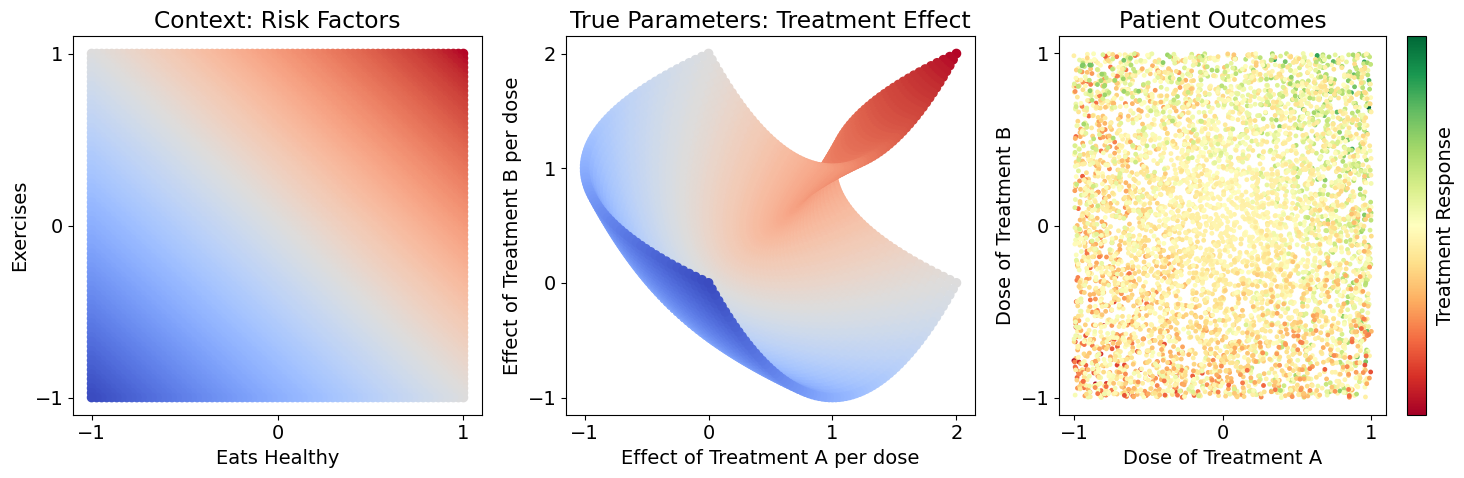

In [3]:
# Preliminary Exploration and Plotting
def cbar(arr):
    c = (arr - arr.mean()) / arr.std()
    return c

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0]

# Plot the context and treatment effect spaces
axs[0].scatter(C[:,0], C[:,1], c=C[:,0]+C[:,1], cmap='coolwarm')
axs[0].set_xlabel('Eats Healthy')
axs[0].set_xticks([-1, 0, 1])
axs[0].set_ylabel('Exercises')
axs[0].set_yticks([-1, 0, 1])
axs[0].set_title('Context: Risk Factors')

axs[1].scatter(betas[:,0], betas[:,1], c=C[:,0]+C[:,1], cmap='coolwarm')
axs[1].set_xlabel('Effect of Treatment A per dose')
axs[1].set_xticks([-1, 0, 1, 2])
axs[1].set_ylabel('Effect of Treatment B per dose')
axs[1].set_yticks([-1, 0, 1, 2])
axs[1].set_title('True Parameters: Treatment Effect')

cplot = axs[2].scatter(X[:,0], X[:,1], c=cbar(Y), s=6., cmap='RdYlGn')
axs[2].set_xlabel('Dose of Treatment A')
axs[2].set_xticks([-1, 0, 1])
axs[2].set_ylabel('Dose of Treatment B')
axs[2].set_yticks([-1, 0, 1])
axs[2].set_title('Patient Outcomes')
plt.colorbar(cplot, ax=axs[2], ticks=[], label='Treatment Response')
plt.tight_layout()
plt.show()

### 1.2: Initial Thoughts

Notice that the patient outcomes seem noisy, but there is no noise in the sample generation. 
The variability among patient responses is due to meaningful variation in each patient's treatment effects, based on their risk factors.
We never observe true models (treatment effects) in real life, so it's easy to attribute variation to meaningless noise.
Here, we won't have that luxury: we'll compare all of our estimates against the true parameters to see how different estimators can generalize over the whole space.

### 1.3 Imposing Realistic Constraints

Let's say our data only contains highly localized populations, i.e. there's only a few hospitals involved in our study, each with non-representative patient populations, but we need to generalize to a much broader population. 
Below, we visualize the sampled vs. entire population, and pick two patients of interest (Jerry and Terry) that aren't in our observed population.
Let's see how different methods generalize to our various populations and patients of interest

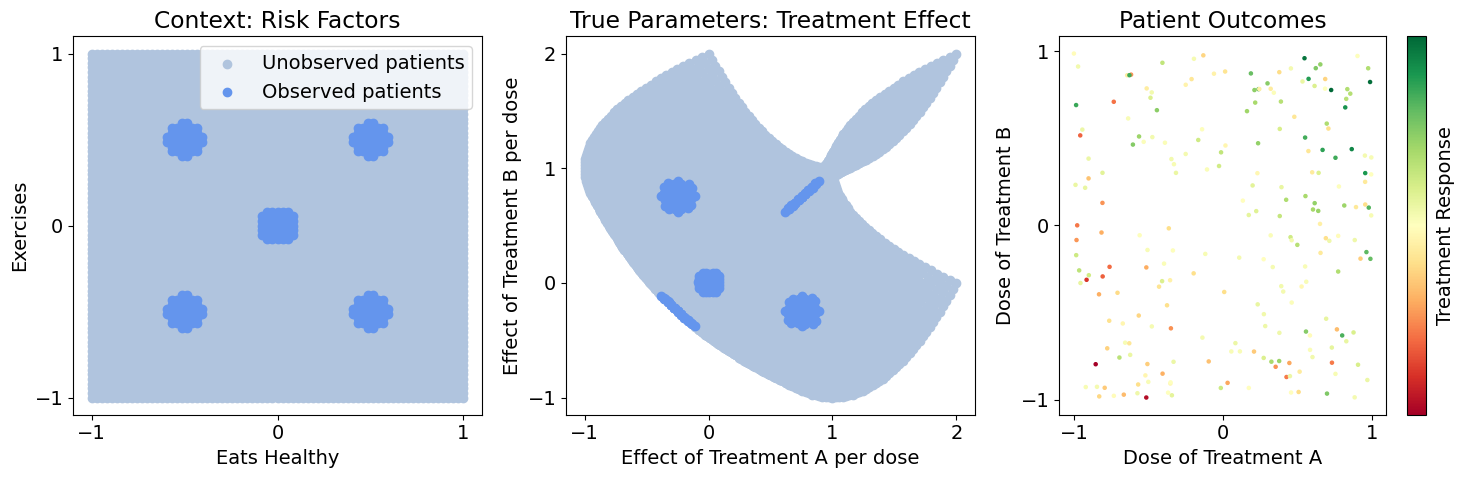

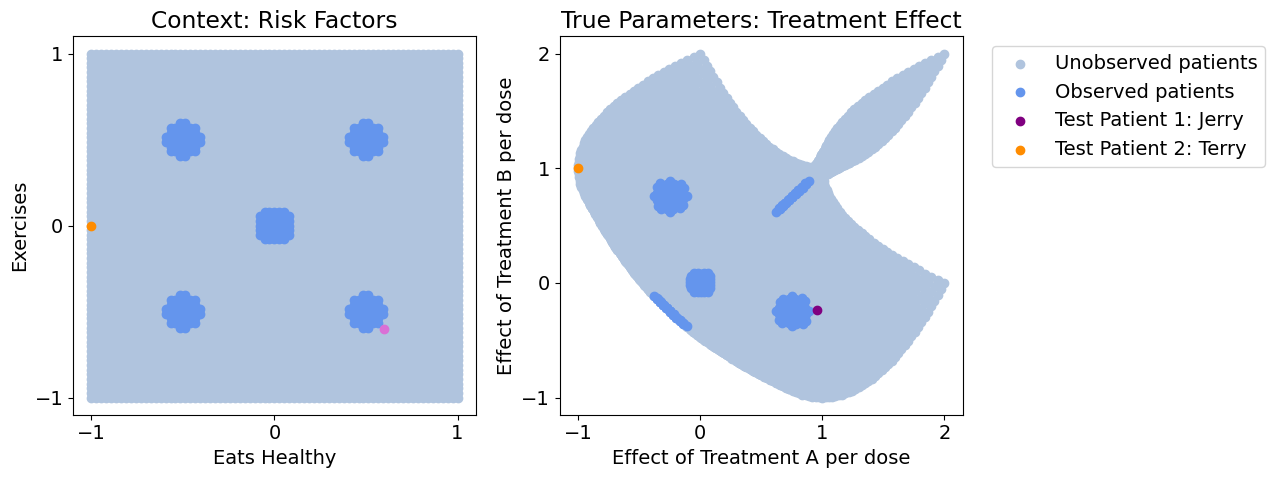

In [4]:
# Plot the observed and unobserved samples
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(C_test_pre[:,0], C_test_pre[:,1], c='lightsteelblue', label='Unobserved patients')
axs[0].scatter(C_train_pre[:,0], C_train_pre[:,1], c='cornflowerblue', label='Observed patients')
axs[0].set_xlabel('Eats Healthy')
axs[0].set_xticks([-1, 0, 1])
axs[0].set_ylabel('Exercises')
axs[0].set_yticks([-1, 0, 1])
axs[0].set_title('Context: Risk Factors')
axs[0].legend()

axs[1].scatter(betas_test[:,0], betas_test[:,1], c='lightsteelblue', label='Unobserved patients')
axs[1].scatter(betas_train[:,0], betas_train[:,1], c='cornflowerblue', label='Observed patients')
axs[1].set_xlabel('Effect of Treatment A per dose')
axs[1].set_xticks([-1, 0, 1, 2])
axs[1].set_ylabel('Effect of Treatment B per dose')
axs[1].set_yticks([-1, 0, 1, 2])
axs[1].set_title('True Parameters: Treatment Effect')

cplot = axs[2].scatter(X_train[:,0], X_train[:,1], c=cbar(Y_train), s=5., cmap='RdYlGn')
axs[2].set_xlabel('Dose of Treatment A')
axs[2].set_xticks([-1, 0, 1])
axs[2].set_ylabel('Dose of Treatment B')
axs[2].set_yticks([-1, 0, 1])
axs[2].set_title('Patient Outcomes')
plt.colorbar(cplot, ax=axs[2], ticks=[], label='Treatment Response')
plt.tight_layout()
plt.show()


# Identify patients of interest
C_patients_pre = np.array([
    [.6, -.6],  # 
    [-1, 0]
])
betas_patients = np.zeros_like(C_patients_pre)
betas_patients[:,0] = C_patients_pre[:,0] + C_patients_pre[:,1]**2 
betas_patients[:,1] = C_patients_pre[:,0]**2 + C_patients_pre[:,1] 

C_patients = (C_patients_pre - C_mean) / C_std
X_patients = np.zeros_like(betas_patients)
Y_patients = np.zeros((len(X_patients), 1))

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].scatter(C_test_pre[:,0], C_test_pre[:,1], c='lightsteelblue', label='Unobserved')
axs[0].scatter(C_train_pre[:,0], C_train_pre[:,1], c='cornflowerblue', label='Observed')
axs[0].scatter(C_patients_pre[0,0], C_patients_pre[0,1], c='orchid', label='Test Patient 1: Jerry')
axs[0].scatter(C_patients_pre[1,0], C_patients_pre[1,1], c='darkorange', label='Test Patient 2: Terry')
axs[0].set_xlabel('Eats Healthy')
axs[0].set_xticks([-1, 0, 1])
axs[0].set_ylabel('Exercises')
axs[0].set_yticks([-1, 0, 1])
axs[0].set_title('Context: Risk Factors')

axs[1].scatter(betas_test[:,0], betas_test[:,1], c='lightsteelblue', label='Unobserved patients')
axs[1].scatter(betas_train[:,0], betas_train[:,1], c='cornflowerblue', label='Observed patients')
axs[1].scatter(betas_patients[0,0], betas_patients[0,1], c='purple', label='Test Patient 1: Jerry')
axs[1].scatter(betas_patients[1,0], betas_patients[1,1], c='darkorange', label='Test Patient 2: Terry')
axs[1].set_xlabel('Effect of Treatment A per dose')
axs[1].set_xticks([-1, 0, 1, 2])
axs[1].set_ylabel('Effect of Treatment B per dose')
axs[1].set_yticks([-1, 0, 1, 2])
axs[1].set_title('True Parameters: Treatment Effect')
axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/patient_trueeffects.png', dpi=300)
plt.show()

### 1.4: Understanding the Problem

It is important to generalize to the unobserved areas because because these gaps often represent:

- Undersampled / underrepresented patient populations
- Undocumented / undiscovered treatments
- Rare cell types / diseases / risk factors

Let's quickly define our evaluation metric (mean squared error) and visualization

In [5]:
mse = lambda true, pred: ((true - pred)**2).mean()

def plot_all(betas_hat, patient_betas_hat, model_name):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6))
    axs[0].scatter(betas_test[:,0], betas_test[:,1], c='lightsteelblue')
    axs[0].scatter(betas_train[:,0], betas_train[:,1], c='cornflowerblue')
    axs[0].scatter(betas_hat[:,0], betas_hat[:,1], c='crimson', label='Predicted Effects (all unobserved)')
    axs[0].set_xticks([-1, 0, 1])
    axs[0].set_yticks([-1, 0, 1])


    axs[1].scatter(betas_test[:,0], betas_test[:,1], c='lightsteelblue', label='True Effects (unobserved patients)')
    axs[1].scatter(betas_train[:,0], betas_train[:,1], c='cornflowerblue', label='True Effects (observed patients)')
    axs[1].scatter([], [], c='crimson', label='Predicted Effects (unobserved patients)')  # dummy plot for legend
    axs[1].scatter(betas_patients[0,0], betas_patients[0,1], c='purple', label='True Effects (Jerry)')
    axs[1].scatter(patient_betas_hat[0,0], patient_betas_hat[0,1], c='pink', label='Predicted Effects (Jerry)')
    axs[1].scatter(betas_patients[1,0], betas_patients[1,1], c='darkorange', label='True Effects (Terry)')
    axs[1].scatter(patient_betas_hat[1,0], patient_betas_hat[1,1], c='gold', label='Predicted Effects (Terry)')
#     axs[1].set_xlabel('Effect of Treatment A per dose')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.add_subplot(111, frameon=False)  # subplot axis hack
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Effect of treatment A per dose')
    axs[1].set_xticks([-1, 0, 1, 2])
    plt.ylabel('Effect of treatment B per dose')
    axs[1].set_yticks([-1, 0, 1, 2])
    plt.title('Model Parameters: Treatment Effects')
    plt.tight_layout()
#     plt.savefig(f'figures/{model_name}_effects.png', dpi=300)
    plt.show()

## Section 2: Approaching the Problem

We'll compare three approaches to modeling treatment response in this patient population:
- Population Regression: Disregard context, assume we can model all patients the same way
- Context-clustered Regression: We know context has some effect on model parameters, so cluster patients according to context and learn a model for each cluster
- Contextualized Regression: Learn how context affects model parameters using Contextualized ML

For each of these models, we'll evaluate how well they recover the following in terms of MSE:
- True patient outcomes / treatment response
- True model parameters

In [6]:
# Define our models
from sklearn.cluster import KMeans
from contextualized.regression import ContextualizedRegression, RegressionTrainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class NaiveRegression:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.x_mu = np.mean(X, axis=0)
        self.y_mu = np.mean(Y, axis=0)
        X_centered = X - self.x_mu
        Y_centered = Y - self.y_mu
        self.betas = np.linalg.inv(X_centered.T @ X_centered) @ X_centered.T @ Y_centered
        return self
        
    def predict_betas(self, X):
        return np.tile(self.betas.T, (len(X), 1))
    
    def predict_y(self, X):
        X_centered = X - self.x_mu
        betas_hat = self.predict_betas(X_centered)
        y_hat = (X_centered * betas_hat).sum(axis=1)[:, np.newaxis] + self.y_mu
        return y_hat


class ClusterRegression:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K)
        self.models = {k: NaiveRegression() for k in range(K)}
    
    def fit(self, C, X, Y):
        self.betadim = X.shape[-1]
        self.kmeans.fit(C)
        for k in range(self.K):
            k_idx = self.kmeans.labels_ == k
            X_k, Y_k = X[k_idx], Y[k_idx]
            self.models[k].fit(X_k, Y_k)
        return self
            
    def predict_labels(self, C):
        return self.kmeans.predict(C)
    
    def predict_betas(self, C, X):
        labels = self.predict_labels(C)
        betas_hat = np.zeros_like(X)
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            betas_hat[l_idx] = self.models[label].predict_betas(X_l)
        return betas_hat
    
    def predict_y(self, C, X):
        labels = self.predict_labels(C)
        y_hat = np.zeros((len(X), 1))
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            y_hat[l_idx] = self.models[label].predict_y(X_l)
        return y_hat

### 2.1: Population Regression
First, we learn a single model from our whole dataset.

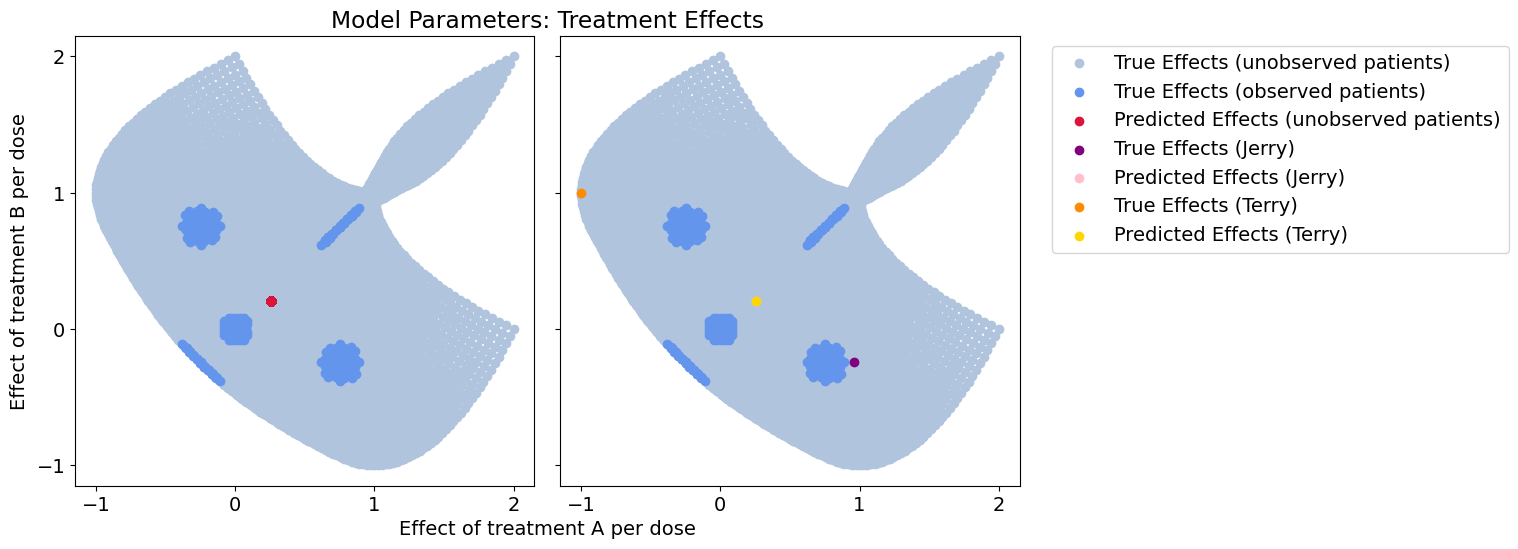

Treatment-response error: 	0.29852483890404086
Effect-size error: 		0.45831411346506756


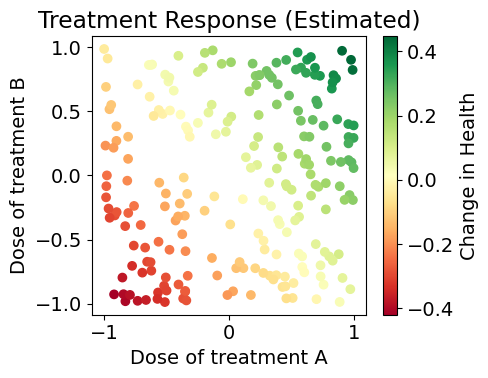

In [7]:
# Population regression
naive_model = NaiveRegression().fit(X_train, Y_train)

betas_hat = naive_model.predict_betas(X_test)
patient_betas_hat = naive_model.predict_betas(X_patients)
y_hat = naive_model.predict_y(X_test)

plot_all(betas_hat, patient_betas_hat, 'population')
y_mse = mse(Y_test, y_hat)
w_mse = mse(betas_test, betas_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

plt.figure(figsize=(5.05,4))
plt.scatter(X_train[:,0], X_train[:,1], c=naive_model.predict_y(X_train), cmap='RdYlGn')
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Change in Health')
plt.title('Treatment Response (Estimated)')
plt.tight_layout()
# plt.savefig('figures/population_responses.png', dpi=300)
plt.show()

In our initial pass we learn a single model from data, which turns out to be the average of all our true models.
This has terrible coverage of our model space, and completely disregards context. 

The predicted effects show how this model only learns a single general trend and ignores meaningful variation among patients (we predict the exact same model for Jerry and Terry!)

### 2.2: Context-clustered Regression
Now, we know there's some contextual effects at play. 
We'll try clustering the data according to the excercise and diet risk factors and see if it improves predictions.

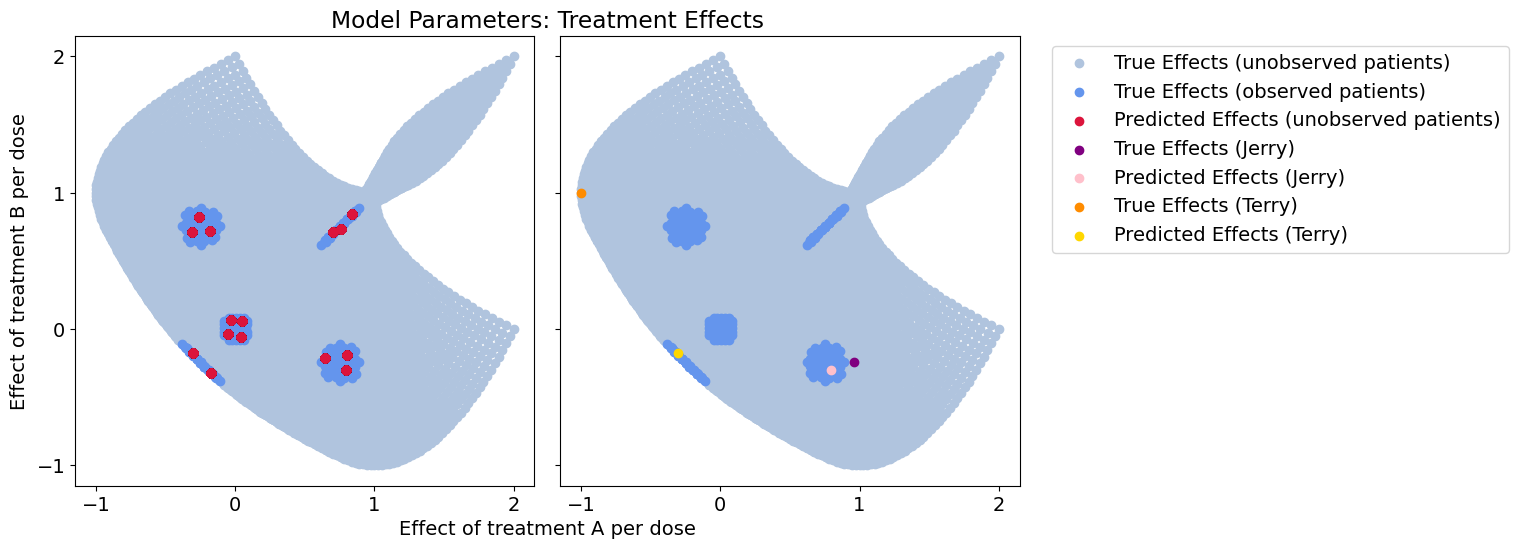

Treatment-response error: 	0.095105776956211
Effect-size error: 		0.1458514219720982


In [8]:
# Cluster regression
cluster_model = ClusterRegression(15).fit(C_train, X_train, Y_train)
betas_hat = cluster_model.predict_betas(C_test, X_test)
y_hat = cluster_model.predict_y(C_test, X_test)
patient_betas_hat = cluster_model.predict_betas(C_patients, X_patients)

plot_all(betas_hat, patient_betas_hat, 'cluster_neat')

y_mse = mse(Y_test, y_hat)
betas_mse = mse(betas_test, betas_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{betas_mse}")

Context-clustering does much better on the unobserved patients than the population model, but we're severely constrained by the breadth of the data we've observed.
For the patient of interest near our observed data, this will work just fine.
However, with higher dimensional data the dataset coverage will always be sparse and new patients rarely match an observed population exactly.

Overall, we get very poor coverage of the overall parameter space, and our our outlier patient will have problems with her treatment.

### 2.3: Context-clustered Regression with Noise

Let's suppose we have bad features in our data. We don't always know exactly what will affect our treatment model, so we'd like to sample as many context features as possible. What happens to the context-clustered model when we have bad features?

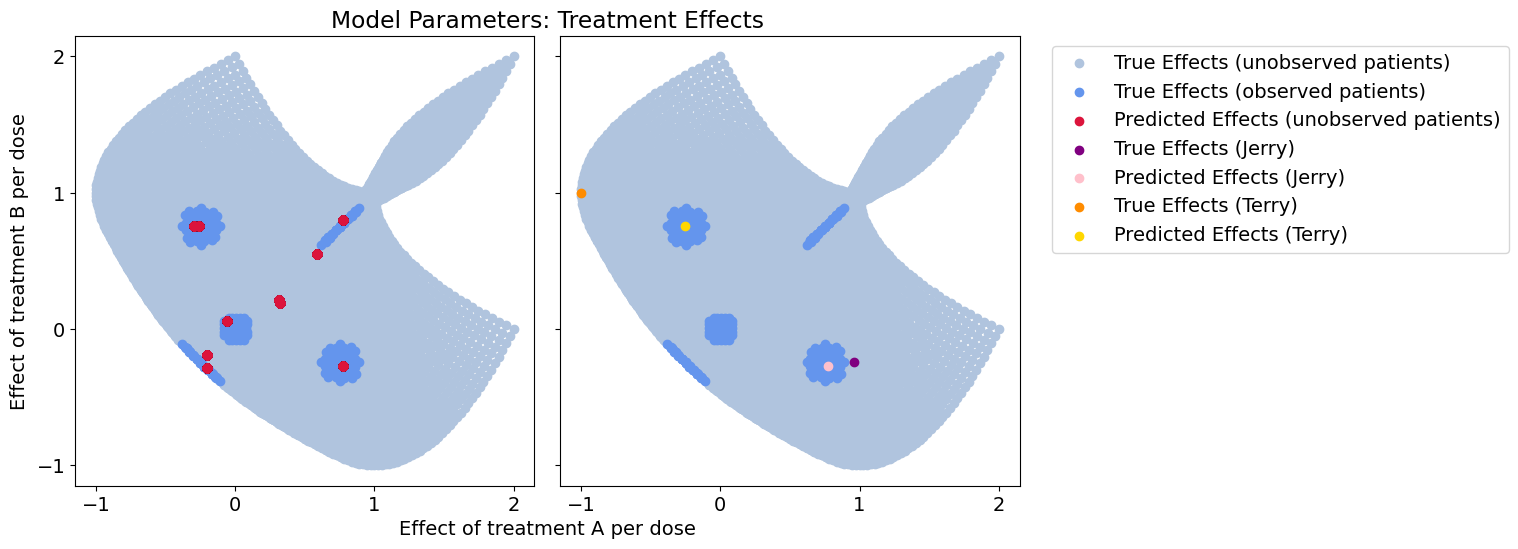

Response error: 0.14038354980340043
Effect-size error: 0.2138811968249326


In [9]:
# Regression from noise-context clustering
noise = np.random.normal(0, 1, (len(C), 2))
noise_train, noise_test = split(noise)
noise_mean, noise_std = noise_train.mean(axis=0), noise_train.std(axis=0)
noise_train = (noise_train - noise_mean) / noise_std
noise_test = (noise_test - noise_mean) / noise_std
C_noise_train = np.concatenate((C_train, noise_train), axis=-1)
C_noise_test = np.concatenate((C_test, noise_test), axis=-1)
C_noise_patients = np.concatenate((C_patients, noise_test[:len(C_patients)]), axis=-1)

cluster_model = ClusterRegression(10).fit(C_noise_train, X_train, Y_train)
betas_hat = cluster_model.predict_betas(C_noise_test, X_test)
y_hat = cluster_model.predict_y(C_noise_test, X_test)
patient_betas_hat = cluster_model.predict_betas(C_noise_patients, X_patients)

plot_all(betas_hat, patient_betas_hat, 'cluster_noisy')

y_mse = mse(Y_test, y_hat)
betas_mse = mse(betas_test, betas_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {betas_mse}")

When we add noise parameters to the context, the cluster approach degrades. 
Here, the coverage we get is due to noisy context and new samples will tend to align with the wrong clusters.

Because we never estimate a functional relationship between context and our treatment effect model, it's very hard to say which context features are meaningful or not.
This is especially difficult if the true relationship is a 2nd order function or higher. 

Clustering in this realistic case marginally improves on the population model.

### 2.4: Contextualized Regression

Now let's learn the function from context to model parameters with Contextualized


In [10]:
%%capture
# Regression from context encoding
encoder_kwargs = {'width': 25, 'layers': 2}
model = ContextualizedRegression(C.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(C_patients, X_patients, Y_patients, batch_size=1)

trainer = RegressionTrainer(max_epochs=50)#, auto_lr_find=True)
trainer.fit(model, train_dataloader)

betas_hat, _ = trainer.predict_params(model, test_dataloader)
betas_hat = betas_hat.squeeze()
y_hat = (X_test * betas_hat).sum(axis=1)[:,np.newaxis]

patient_betas_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_betas_hat = patient_betas_hat.squeeze()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 1.0 K 
-----------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=50` reached.


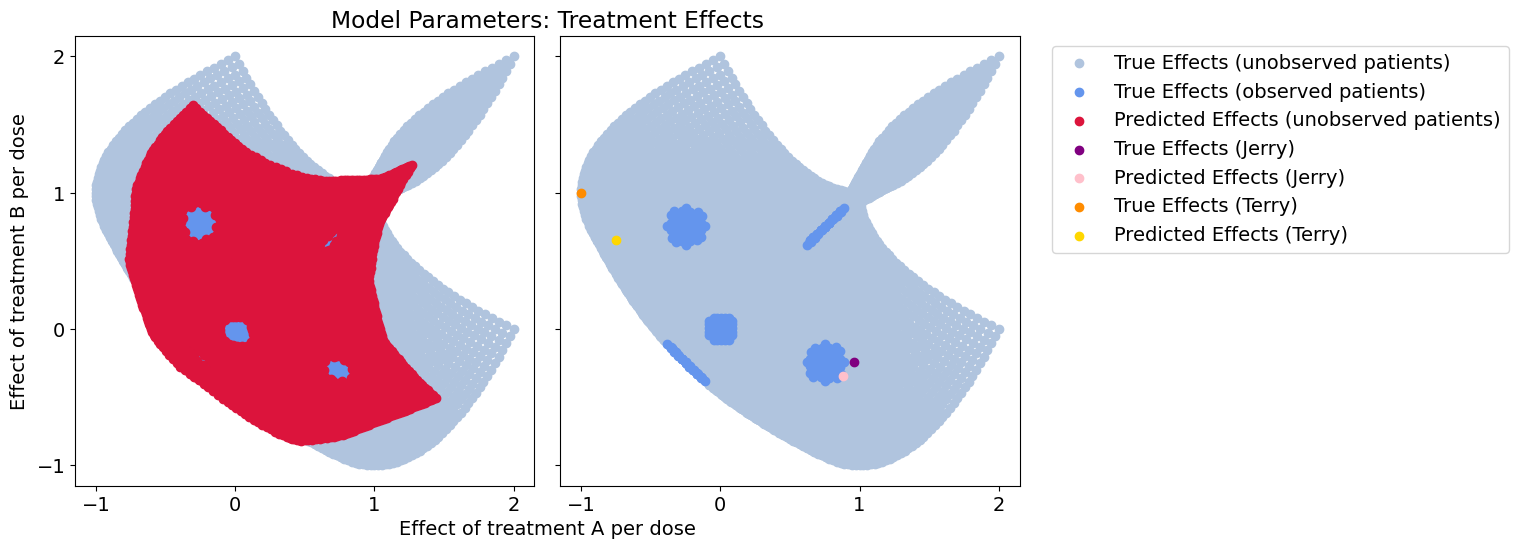

Response error: 0.025793352019927752
Effect-size error: 0.03898791977626924


In [11]:
plot_all(betas_hat, patient_betas_hat, 'encoder')

y_mse = mse(Y_test, y_hat)
betas_mse = mse(betas_test, betas_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {betas_mse}")

Wow! We get an order of magnitude better generalization, and much better coverage of the parameter space by learning a functional relationship between context and our models of treatment effects

### 2.5: Contextualized Regression on Noise

For a quick sanity check, let's test what happens when we feed our context encoder __only__ noise. 

In [12]:
%%capture
# Regression from noise encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(noise.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(noise_train, X_train, Y_train, batch_size=10)
test_dataloader = model.dataloader(noise_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(noise_test[:len(C_patients)], X_patients, Y_patients, batch_size=1)
trainer = RegressionTrainer(max_epochs=20)#, auto_lr_find=True)
trainer.fit(model, train_dataloader)

betas_hat, _ = trainer.predict_params(model, test_dataloader)
betas_hat = betas_hat.squeeze()
y_hat = (X_test * betas_hat).sum(axis=1)[:,np.newaxis]

patient_betas_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_betas_hat = patient_betas_hat.squeeze()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 3.2 K 
-----------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.


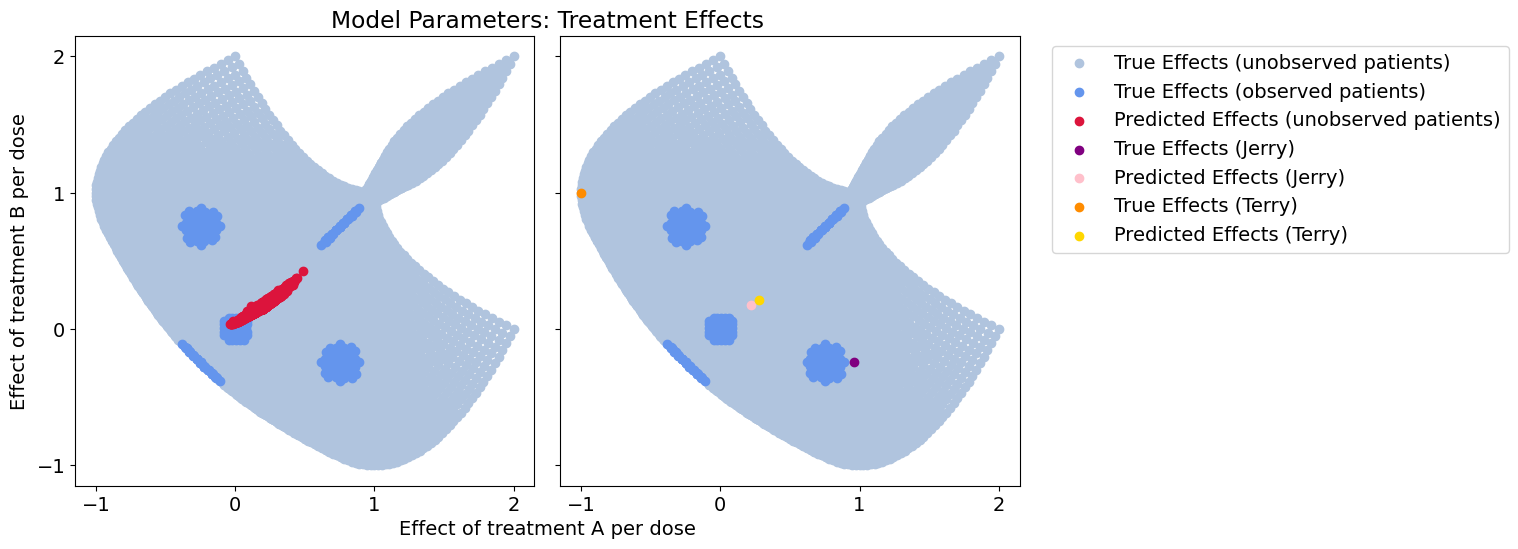

Response error: 0.30515066015316983
Effect-size error: 0.4691279927863987


In [13]:
plot_all(betas_hat, patient_betas_hat, 'encoder_noise')

y_mse = mse(Y_test, y_hat)
betas_mse = mse(betas_test, betas_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {betas_mse}")

Nice! For a completely uninformative context, we can do no worse than the population model, which also assumes context is meaningless.

### 2.6: Contextualized Regression with Bad Features

Now, we might be able to use the context encoder to do automatic feature selection and knowledge distillation.
If only some features are useful, the context encoder should learn to use these over the bad/noisy features and produce a near-identical mapping as the contextualized regression with no noise.

In [14]:
%%capture
# Regression from noisy context encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(C_noise_train.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_noise_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(C_noise_patients, X_patients, Y_patients, batch_size=1)

trainer = RegressionTrainer(max_epochs=50)#, auto_lr_find=True)
trainer.fit(model, train_dataloader)

betas_hat, _ = trainer.predict_params(model, test_dataloader)
betas_hat = betas_hat.squeeze()
y_hat = (X_test * betas_hat).sum(axis=1)[:,np.newaxis]

patient_betas_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_betas_hat = patient_betas_hat.squeeze()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 3.3 K 
-----------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=50` reached.


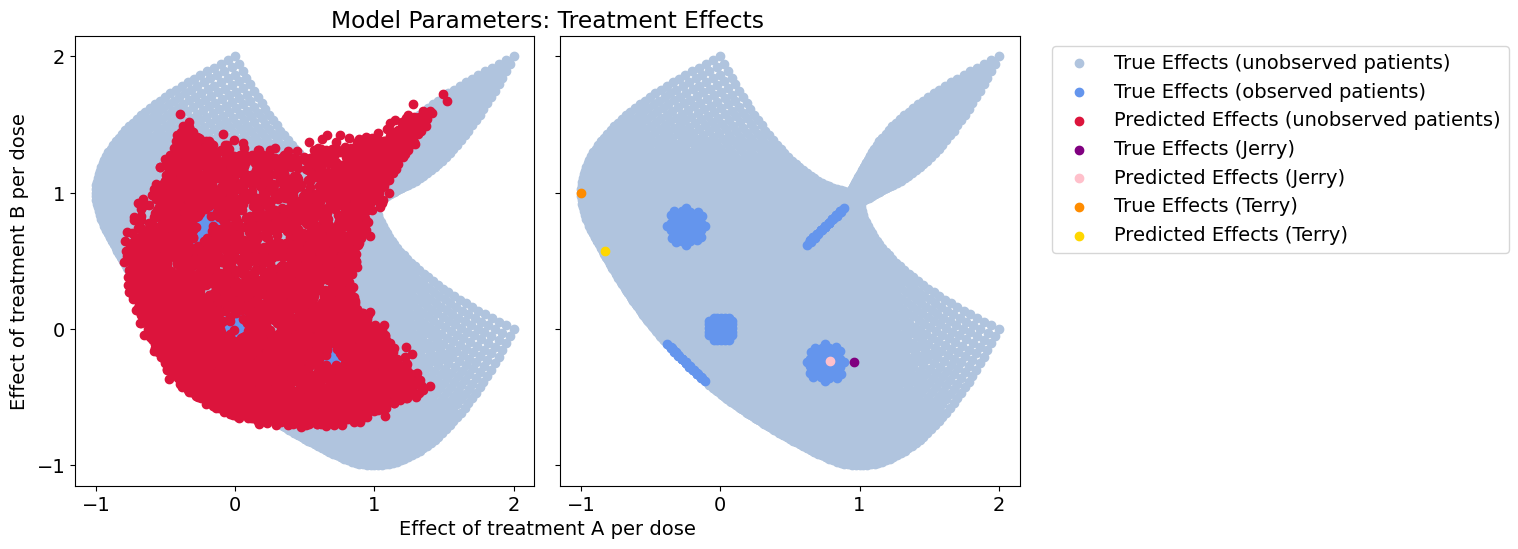

Response error: 0.029984110809356892
Effect-size error: 0.04454759860786668


In [15]:
plot_all(betas_hat, patient_betas_hat, 'encoder_somenoise')

y_mse = mse(Y_test, y_hat)
betas_mse = mse(betas_test, betas_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {betas_mse}")

Cool, looks like feature selection works pretty well and we get near-identical predictions to before.
If we used an interpretable context encoder like a neural additive models, we could infer the exact effect of each context feature and how useful it is.

### 2.7: Throw a deep learner at it!

Given that our approach requires the use of a deep learner, it's natural to wonder whether the "secret sauce" here is contextualized modeling or the deep learner itself.
Luckily, our simulation setup allows us to compare these two approaches directly. 

Here, we'll train a standard neural network to predict outcomes from context and dose.
Afterward, we can compare outcome accuracy, but also compare the treatment effect models our neural network learned!
Since we're using linear models in our simulation, we can use the differentiability of neural networks to discover implicit representations of feature derivatives (i.e. linear model parameters)!

In [16]:
%%capture
# gradient models from MLP(CX) -> Y
from contextualized.modules import MLP

def get_grad(model, X):
    X.requires_grad = True
    for i in range(len(X)):
        yhat = model(X)
        yhat[i].backward()
    betas_hat = X.grad.clone()
    X.requires_grad = False
    return betas_hat

CX = torch.tensor(np.concatenate((C, X), axis=-1), dtype=torch.float32)
CX_patients = torch.tensor(np.concatenate((C_patients, X_patients), axis=-1), dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_patients = torch.tensor(Y_patients, dtype=torch.float32)

CX_train, CX_test = split(CX)
mlp = MLP(CX.shape[-1], Y.shape[-1], 50, 2)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)
for _ in range(1000):
    loss = mse(mlp(CX_train), Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
train_w_hat_train = get_grad(mlp, CX_train)[:,-X.shape[-1]:]
test_betas_hat = get_grad(mlp, CX_test)[:,-X.shape[-1]:]
patient_betas_hat = get_grad(mlp, CX_patients)[:,-X_patients.shape[-1]:]

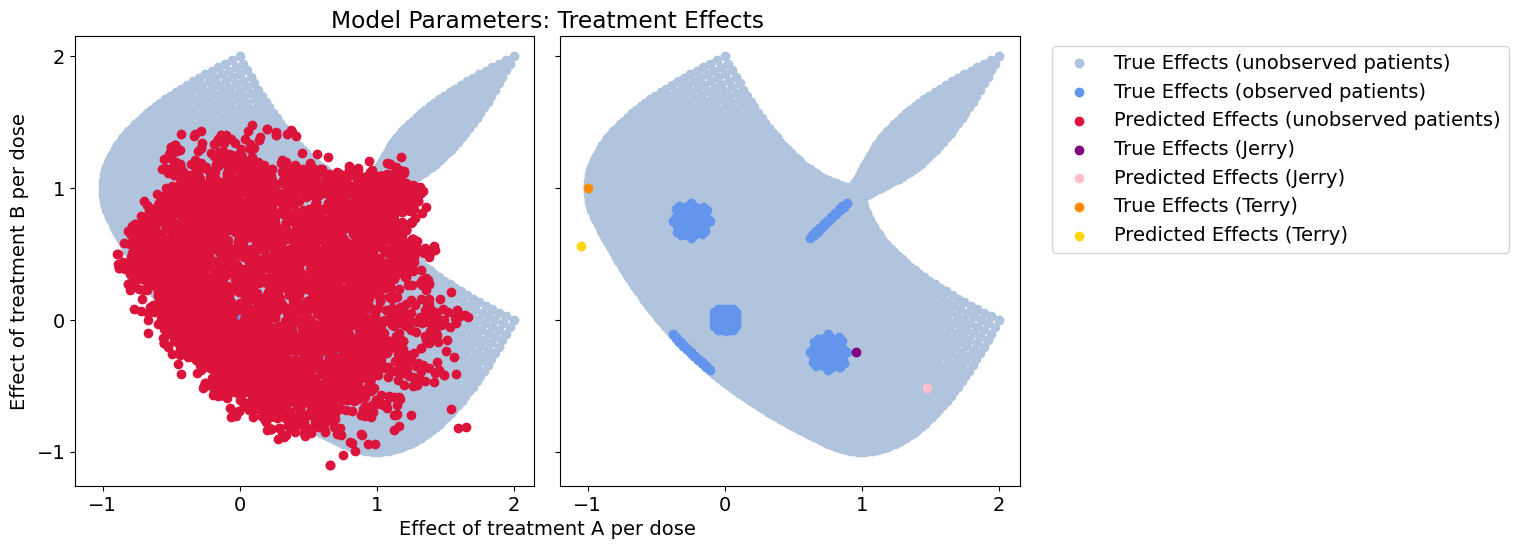

Response error: 0.043704550713300705
Effect-size error: 0.08661885559558868


In [17]:
plot_all(test_betas_hat, patient_betas_hat, 'cx_mlp')

y_mse = mse(Y_test, mlp(CX_test))
betas_mse = mse(torch.tensor(betas_test, dtype=torch.float32), test_betas_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {betas_mse}")

Wow! What a mess.

The implicit model representation in the neural network is highly disorganized compared to Contextualized models, and leads to much worse predictions.


### Summary
Contextualized models improve over both deep learners as well as traditional regression.
Contextualized models benefit from the flexibility of a deep learner during training, but we enforce an explicit representation of model parameters within the deep learner.
The end result is the same type of models that are produced by the cluster analysis or population modeling methods, but each model is personalized based on an individual patient's context.